In [ ]:
# https://www.kaggle.com/code/dimasmunoz/text-classification-with-roberta-and-tpus

In [1]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 300

In [16]:
import tensorflow as tf
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import transformers
from transformers import RobertaTokenizerFast
import json
import matplotlib.pyplot as plt
import random
import seaborn as sns
import pandas as pd
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification


In [4]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [5]:
from __future__ import print_function
import ipywidgets as widgets
import re
from sklearn.preprocessing import LabelEncoder

In [6]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [7]:
df = pd.read_csv("data_transformer.csv")

In [8]:
df.head()

,text_clean,target
0,from a gender perspective paulgaard points out...,5
1,the average figure also masks large difference...,3
2,the israel oceanographic and limnological rese...,6
3,previous chapters have discussed ways to make ...,2
4,prescription rates appear to be higher where l...,8


In [9]:
sentences = df['text_clean'].values

In [10]:
# Simple cleaning of text ahead of summarisation

def clean_text(text):
    text = text.encode("ascii", errors="ignore").decode("ascii") #remove non-ascii, Chinese characters
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"\n\n", " ", text)
    text = re.sub(r"\W", " ", text)
    text = re.sub(r"^\d+\s|\s\d+\s|\s\d+$", " ", text)
    text = text.strip(" ")
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(' +',' ', text).strip() # get rid of multiple spaces and replace with a single
    return text


In [11]:
df["text_clean"] = df["text_clean"].apply(lambda text:clean_text(str(text)))

<Axes: xlabel='target', ylabel='count'>

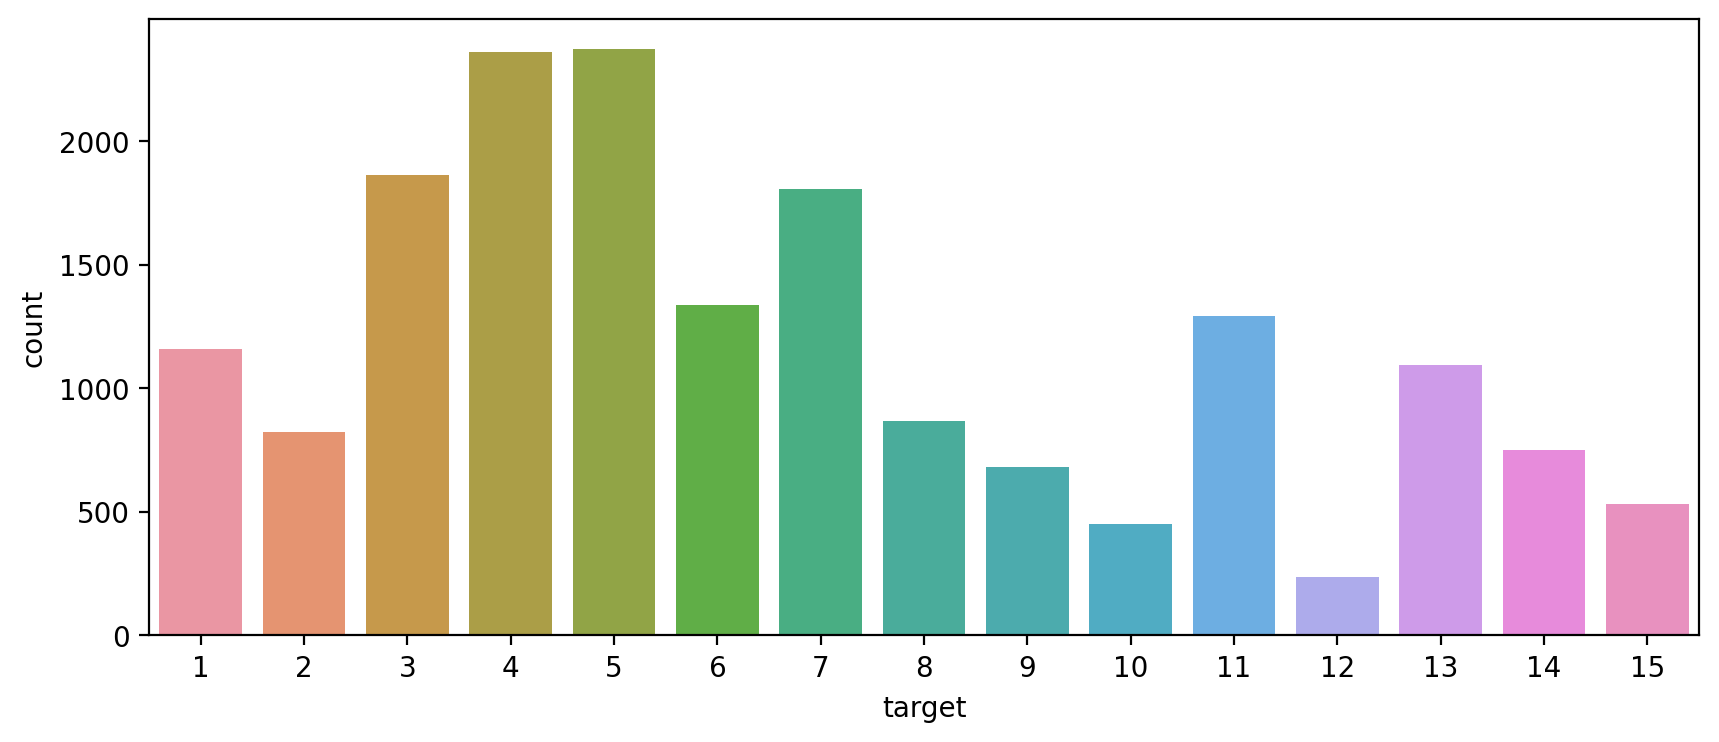

In [12]:
plt.figure(figsize=(10,4),dpi=200)
sns.countplot(x='target',data=df)

In [13]:
X_train,X_test ,y_train,y_test = train_test_split(df['text_clean'], 
                                                  df['target'], random_state = 42, test_size = 0.2)

In [14]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base") #Tokenizer
train_inputs = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='tf') #Tokenized text
train_labels = y_train
test_inputs = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors='tf') #Tokenized text
test_labels = y_test

In [25]:
model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=16)

model.compile(

        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001, clipnorm=1.),

        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),

        metrics=[tf.metrics.SparseCategoricalAccuracy()],

        )
model.summary()

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_roberta_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 602896    
 ficationHead)                                                   
                                                                 
Total params: 124,657,936
Trainable params: 124,657,936
Non-trainable params: 0
_________________________________________________________________


In [55]:
history_own=LossOnHistoryRobert(dict(test_inputs),test_labels) 
history=model.fit(dict(train_inputs),train_labels, validation_data=[dict(test_inputs),test_labels], batch_size=16,epochs=1, verbose=1)

882/882 [==============================] - 13422s 15s/step - loss: 0.3289 - sparse_categorical_accuracy: 0.9110 - val_loss: 0.3897 - val_sparse_categorical_accuracy: 0.8962


In [68]:
preds = model.predict(dict(test_inputs))

111/111 [==============================] - 800s 7s/step


In [69]:
predicted = preds['logits']

In [70]:
pred_classes = np.argmax(predicted, axis = 1)
pred_classes

array([ 3,  7, 11, ..., 13,  1,  7], dtype=int64)

In [71]:
result_df = pd.DataFrame({'description':X_test,'true_category':y_test, 'predicted_category':pred_classes})
result_df.head()

,description,true_category,predicted_category
7168,there are several programmes and initiatives w...,3,3
5464,these conventional plants run less frequently ...,7,7
5809,a betterdesigned approach could help win suppo...,11,11
16100,wind production capacity and demand profiles a...,7,7
14950,in kamali however the early warning system wor...,13,13


In [72]:
print(f"Accuracy is {sklearn.metrics.accuracy_score(result_df['true_category'], result_df['predicted_category'])}")

Accuracy is 0.8962290898780834


In [56]:
test_df = pd.read_excel("test_dataset.xlsx")

In [57]:
test_df.head()

,News Summary,OSDG,OSDG Label
0,agricultural engineer eduardo assad has devot...,Climate Action,13
1,agricultural organizations are joining forces...,Zero Hunger,2
2,aim4c coalition pledged to accelerate innovat...,Climate Action,13
3,alaa abd el fattah has been unlawfully impris...,Climate Action,13
4,alaa abd el fattah one of egypts most high pr...,Climate Action,13


In [58]:
news = test_df['News Summary']
labels = test_df['OSDG Label']

In [59]:
tokenized_news = tokenizer(news.tolist(), padding=True, truncation=True, return_tensors='tf') #Tokenized text

In [60]:
predicted_news = model.predict(dict(tokenized_news))

56/56 [==============================] - 553s 10s/step


In [61]:
predicted_news = predicted_news['logits']

In [62]:
pred_classes = np.argmax(predicted_news, axis = 1)
pred_classes

array([13,  2, 13, ..., 13, 13,  2], dtype=int64)

In [63]:
result_df = pd.DataFrame({'news':test_df['News Summary'],'true_category':test_df['OSDG Label'], 'predicted_category':pred_classes})
result_df

,news,true_category,predicted_category
0,agricultural engineer eduardo assad has devot...,13,13
1,agricultural organizations are joining forces...,2,2
2,aim4c coalition pledged to accelerate innovat...,13,13
3,alaa abd el fattah has been unlawfully impris...,13,13
4,alaa abd el fattah one of egypts most high pr...,13,13
...,...,...,...
1777,Young activists from outside the country espec...,13,13
1778,Youth climate activism is bearing fruit our an...,13,13
1779,Youth climate activist greta thunberg has a bo...,13,13
1780,Zambia's environment minister collins nzovu de...,13,13


In [64]:
print(f"Accuracy is {sklearn.metrics.accuracy_score(result_df['true_category'], result_df['predicted_category'])}")

Accuracy is 0.8434343434343434


In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

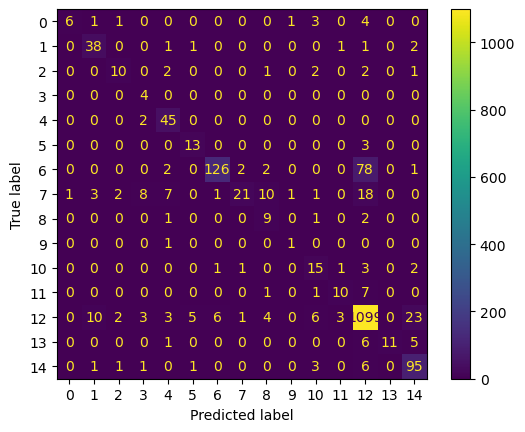

In [67]:
cm = confusion_matrix(result_df['true_category'], result_df['predicted_category'])
ConfusionMatrixDisplay(cm).plot()

In [73]:
 # saving the excel
file_name = 'roberta_results.xlsx'
result_df.to_excel(file_name)